# Example: Kangaroo Detection

We congratulate on you to finish the previous practice and have understanding of python basics, machine learning and image classification. And we welcome you to this level that is about object detection with machine learning.




This is a quick and good start and intro to using the pre-trained model to detect objects. And the code is referred from the Mask R-CNN github (https://github.com/matterport/Mask_RCNN/tree/master/samples) and the blog (https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/). More examples can be found from there. The enviroment is built up in this Notebook and the code can be directly running.

This notebook shows how to train Mask R-CNN on your own dataset. We use the dataset from the github (https://github.com/experiencor/kangaroo) and modify it to suit our situation. The dataset is not big, so it requires less training time. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. 

## Table of content


* Set up environment
* Load images dataset
* Data preparation and configurations
* Train custom model
* Evaluate the model
* Inference

# Set up environment

We will install Mask R-CNN repo from Github (https://github.com/matterport/Mask_RCNN) and necessary packages. We need to make sure the packages we are using is the correct version. 

In [1]:
!pip install tensorflow==1.15.0
!pip install keras==2.1.6
!pip install h5py==2.10.0
!pip install scikit-image==0.16.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 412.3 MB 24 kB/s 
     |████████████████████████████████| 503 kB 61.1 MB/s 
     |████████████████████████████████| 50 kB 7.1 MB/s 
     |████████████████████████████████| 3.8 MB 43.2 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=e1916fe00d190929fdb9e28835443e5b1e8f4e7400f9ff169e16c1c3f41b80be
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting un

In [2]:
%%shell
# clone Mask_RCNN repo and install packages
git clone https://github.com/matterport/Mask_RCNN
cd Mask_RCNN
python setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 22.48 MiB/s, done.
Resolving deltas: 100% (565/565), done.
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdis

In [3]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

Using TensorFlow backend.


... done downloading pretrained model!


# Load images dataset

We will clone the project from our github (https://github.com/BaosenZ/amoeba-detection.git). The dataset is included inside the github project. 

In [4]:
# download dataset from github

%%shell
git clone https://github.com/BaosenZ/amoeba-detection.git


Cloning into 'amoeba-detection'...
remote: Enumerating objects: 2453, done.
remote: Counting objects: 100% (378/378), done.
remote: Compressing objects: 100% (201/201), done.
remote: Total 2453 (delta 178), reused 376 (delta 177), pack-reused 2075
Receiving objects: 100% (2453/2453), 354.59 MiB | 34.85 MiB/s, done.
Resolving deltas: 100% (503/503), done.
Checking out files: 100% (3425/3425), done.


In [5]:
# copy the dataset from github folder to 'content' 

!cp -r '/content/amoeba-detection/dataset-level2/kangarooDataset/trainingDataset' '/content'
!cp -r '/content/amoeba-detection/dataset-level2/kangarooDataset/testDataset' '/content'

In [ ]:
# upload zip of the dataset from local

# from google.colab import files
# uploaded = files.upload()
# for fn in uploaded.keys():
#     print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

# !unzip trainingDataset.zip
# !unzip testDataset.zip

# Data preparation and configurations

In [6]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

class KangarooDataset(Dataset):
	def load_dataset(self, dataset_dir, is_train=True):
		# Add classes
		self.add_class("dataset", 1, "kangaroo")
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		for filename in listdir(images_dir):
			image_id = filename[:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# based on images number, split the training and validation data
			if is_train and int(image_id) >= 160:
				continue
			if not is_train and int(image_id) < 160:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		tree = ElementTree.parse(filename)
		root = tree.getroot()
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		info = self.image_info[image_id]
		path = info['annotation']
		boxes, w, h = self.extract_boxes(path)
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('kangaroo'))
		return masks, asarray(class_ids, dtype='int32')

	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# prepare train set
train_set = KangarooDataset()
train_set.load_dataset('trainingDataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare val set
val_set = KangarooDataset()
val_set.load_dataset('trainingDataset', is_train=False)
val_set.prepare()
print('Val: %d' % len(val_set.image_ids))


Train: 141
Val: 22


Config files allow you to separate the code from the parameters of the machine learning pipeline to help produce repeatable outcomes.

In [7]:
# prepare config
class KangarooConfig(Config):
	# Give the configuration a recognizable name
	NAME = "kangaroo_cfg"
	# Number of classes (including background)
	NUM_CLASSES = 1 + 1 # background + 1 kangaroo
	# Use a small epoch since the data is simple
	STEPS_PER_EPOCH = 131
	DETECTION_NMS_THRESHOLD = 0.5

config = KangarooConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

# Train custom model

In machine learning, to improve something you often need to be able to measure it. TensorBoard is a tool for providing the measurements and visualizations needed during the machine learning workflow. More information about Tensorboard is available here (https://www.tensorflow.org/tensorboard/get_started). 

In [8]:
# run tensorboard to visualize training
import keras
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
print(run_logdir)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

./my_logs/run_2022_06_20-21_25_52


The Mask R-CNN structure is described in the paper(He, K., Gkioxari, G., Dollár, P. and Girshick, R., 2017. Mask r-cnn. In Proceedings of the IEEE international conference on computer vision (pp. 2961-2969).) and also in my ppt. 

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# train the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
model.load_weights('Mask_RCNN/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
model.train(train_set, val_set, learning_rate=0.002, epochs=5, layers='heads', custom_callbacks=[tensorboard_cb])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead







Starting at epoch 0. LR=0.002

Checkpoint Path: ./kangaroo_cfg20220620T2126/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_

/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/5
130/131 [============================>.] - ETA: 1s - loss: 0.9545 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2123 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.3263 - mrcnn_mask_loss: 0.3703

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2348: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


131/131 [==============================] - 229s 2s/step - loss: 0.9505 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.3245 - mrcnn_mask_loss: 0.3690 - val_loss: 0.7111 - val_rpn_class_loss: 0.0075 - val_rpn_bbox_loss: 0.2630 - val_mrcnn_class_loss: 0.0386 - val_mrcnn_bbox_loss: 0.1787 - val_mrcnn_mask_loss: 0.2232

Epoch 2/5
131/131 [==============================] - 179s 1s/step - loss: 0.5645 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1512 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.1444 - mrcnn_mask_loss: 0.2345 - val_loss: 0.6792 - val_rpn_class_loss: 0.0088 - val_rpn_bbox_loss: 0.3024 - val_mrcnn_class_loss: 0.0301 - val_mrcnn_bbox_loss: 0.1269 - val_mrcnn_mask_loss: 0.2110
Epoch 3/5
131/131 [==============================] - 179s 1s/step - loss: 0.4903 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1553 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.0982 - mrcnn_mask_loss: 0.2056 - val_loss: 0.8291 - val_rpn_class_loss: 0.0121 

# Evaluate the model
 


Evaluate the mask rcnn model on the training, validation and test amoeba dataset

In [10]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

class PredictionConfig(Config):
	NAME = "kangaroo_cfg"
	NUM_CLASSES = 1 + 1
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		scaled_image = mold_image(image, cfg)
		sample = expand_dims(scaled_image, 0)
		yhat = model.detect(sample, verbose=0)
		r = yhat[0]
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		APs.append(AP)
	mAP = mean(APs)
	return mAP


In [11]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

# !!!load model weights
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")

# find last trained weights: 
model_path = model.find_last()
model.load_weights(model_path, by_name=True)

# set a specific path
#model.load_weights('zebra_cfg20210206T1746/mask_rcnn_zebra_cfg_0001.h5', by_name=True)  # change the weights path to run the code



Instructions for updating:
Use `tf.cast` instead.
Re-starting from epoch 5


In [12]:
# load the train dataset
train_set = KangarooDataset()
train_set.load_dataset('trainingDataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# load the val dataset
val_set = KangarooDataset()
val_set.load_dataset('trainingDataset', is_train=False)
val_set.prepare()
print('Val: %d' % len(val_set.image_ids))
# load the test dataset
test_set = KangarooDataset()
test_set.load_dataset('testDataset')
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))


# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
val_mAP = evaluate_model(val_set, model, cfg)
print("Val mAP: %.3f" % val_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Train: 141
Val: 22
Test: 20
Train mAP: 0.914
Val mAP: 0.985
Test mAP: 0.983


In [ ]:
# visualize training in Tensorboard

# The tensorboard file name can be found in 'my_logs'. Then change the tensorboard file name.

# %load_ext tensorboard
# %tensorboard --logdir ./my_logs/run_2022_06_20-21_25_52

# Inference


We will detect the images in `testDataset` folder by calling `model.detect()`.

In [14]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def save_predicted(image, model, cfg, filename):
  image = np.asanyarray(image)
  scaled_image = mold_image(image, cfg)
  sample = expand_dims(image, 0)
  yhat = model.detect(sample, verbose=0)[0]
  pyplot.imshow(image)
  ax = pyplot.gca()
  pyplot.axis("off")
  for box,confidence in zip(yhat['rois'],yhat['scores']):
    # if the confidence is larger than 0.96, draw bounding box for the detected object 
    if confidence >= 0.96:
      y1, x1, y2, x2 = box
      width, height = x2 - x1, y2 - y1
      rect = Rectangle((x1, y1), width, height, fill=False, color='red')
      pyplot.text(x1,y1,confidence)
      ax.add_patch(rect)

  pyplot.savefig(filename,bbox_inches='tight',pad_inches=0.0)
  pyplot.show()


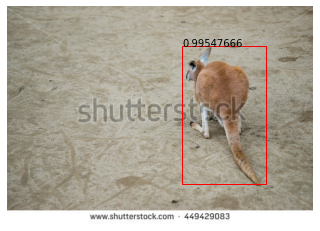

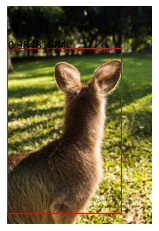

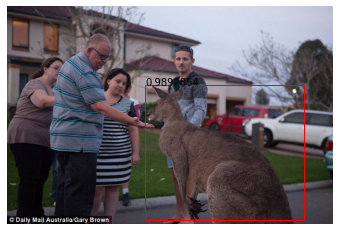

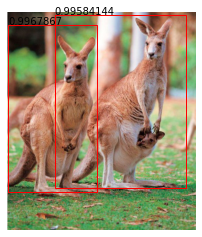

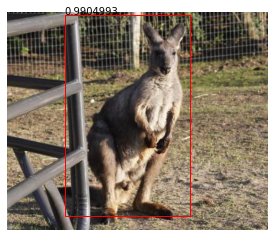

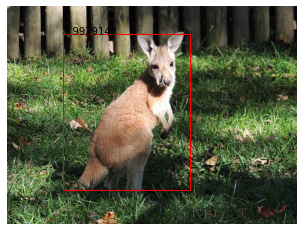

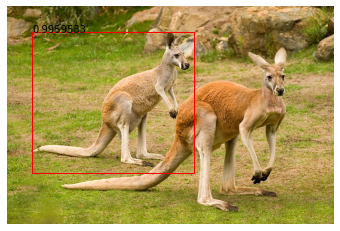

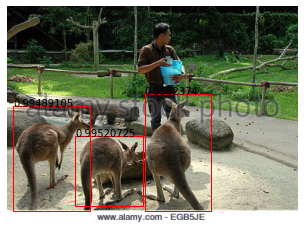

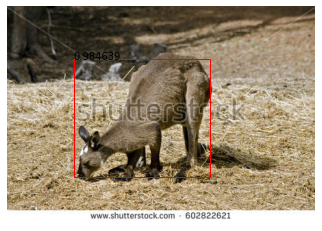

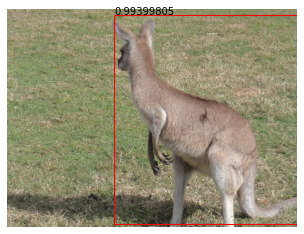

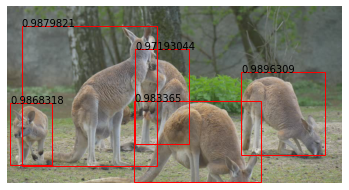

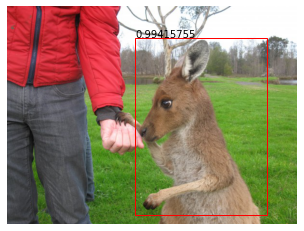

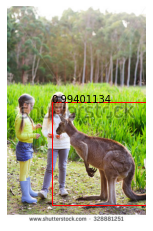

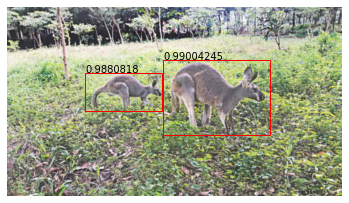

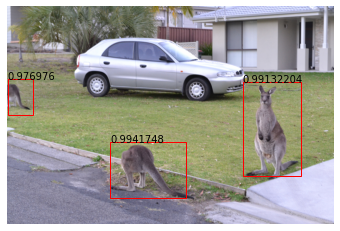

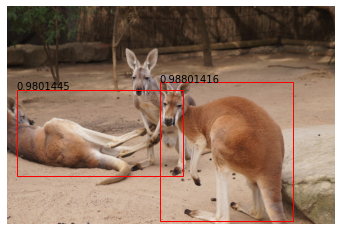

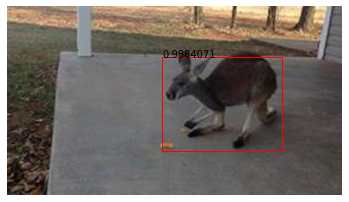

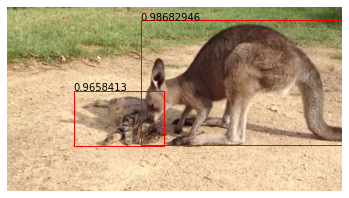

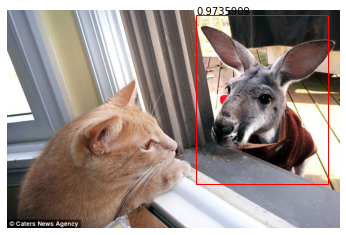

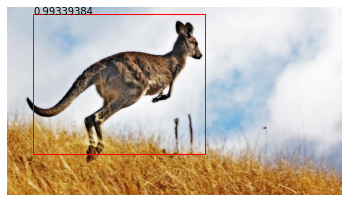

In [15]:
# create folder to save inference images
from PIL import Image
if not os.path.exists("testDataset-pred"):
  os.mkdir("testDataset-pred")

# find the path of original inference images
images_dir = "testDataset/images"
save_root = "testDataset-pred/"
# run the inference
for img in listdir(images_dir):
  img_path = images_dir + "/" + img
  image = Image.open(img_path)
  image = np.asanyarray(image)
  save_file = save_root + img
  save_predicted(image, model, cfg, save_file)
  

In [ ]:
# save the inference folder to local

# !zip -r testDataset-pred.zip testDataset-pred
# from google.colab import files
# files.download("testDataset-pred.zip")